In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

df_train = pd.read_csv('../../../Deceptive_Opinion_Spam_Corpus_Datasets/deceptive_training_sin_proc.csv')
df_test = pd.read_csv('../../../Deceptive_Opinion_Spam_Corpus_Datasets/deceptive_testing_sin_proc.csv')

In [2]:
### Remplazar los truthful con 0 y deceptive con 1 en la columna deceptive
df_train = df_train.replace({'deceptive': {'truthful': 0, 'deceptive': 1}})
df_test = df_test.replace({'deceptive': {'truthful': 0, 'deceptive': 1}})

In [3]:
train_dec_a = df_train.iloc[:, 0]
#validation_dec_a = validation_set.iloc[:, 0]
test_dec_a = df_test.iloc[:, 0]

train_dec_a.columns = ['train_dec_a']
#validation_dec_a.columns = ['validation_dec_a']
test_dec_a.columns = ['test_dec_a']

In [4]:
print(df_train)

     deceptive                                               text
0            0  -0.19499199 -0.11689109 -1.0239629 0.589182 -0...
1            0  -0.75981146 -0.6247913 -0.5968303 0.8442113 -0...
2            0  -0.67143595 -0.34271178 -0.6285268 0.46137583 ...
3            0  -0.3716615 -0.6101102 -0.6716857 1.4250252 -0....
4            0  0.09419579 0.02537344 -0.07499692 1.4799229 -0...
..         ...                                                ...
592          0  -0.7387875 -0.31224024 -0.71631956 0.7961637 -...
593          0  -0.6691669 -0.8395288 -0.88937396 0.82928854 -...
594          0  -0.47775698 -0.21484302 -0.7292124 0.70525247 ...
595          0  -0.051372834 -0.48699462 -0.95044464 1.4210202...
596          0  -0.71351445 0.17851919 -0.258802 1.0437325 -0....

[597 rows x 2 columns]


In [5]:

x_train = ()
y_train = ()

for index, row in df_train.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_train = x_train + (res,)
    y_train = y_train + (row['deceptive'],)

x_test = ()
y_test = ()

for index, row in df_test.iterrows():
    res = list(map(float, row['text'].split(' ')))
    res = np.asarray(res, dtype=np.float32)
    x_test = x_test + (res,)
    y_test = y_test + (row['deceptive'],)


In [6]:
import numpy
arrays = {}
## Train dataset
for i in range(0, len(x_train[0])):
    col_name = 'value_' + str(i)
    arrays[col_name] = numpy.array([item[i] for item in x_train])

train_ext = pd.DataFrame(y_train, columns =['deceptive'])

for x in arrays.keys(): 
    dataframe=pd.DataFrame(arrays[x], columns=[x]) 
    train_ext = train_ext.join(dataframe, how="inner")
    
train_ext = train_ext.drop(['deceptive'],axis=1)
## Test dataset

for i in range(0, len(x_test[0])):
    col_name = 'value_' + str(i)
    arrays[col_name] = numpy.array([item[i] for item in x_test])

test_ext = pd.DataFrame(y_test, columns =['deceptive'])

for x in arrays.keys(): 
    dataframe=pd.DataFrame(arrays[x], columns=[x]) 
    test_ext = test_ext.join(dataframe, how="inner")
    
test_ext = test_ext.drop(['deceptive'],axis=1)


In [7]:
import numpy as np
x_train, y_train = np.asarray(x_train), np.asarray(y_train)
#x_validation, y_validation = np.asarray(x_validation), np.asarray(y_validation)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)

x_train = x_train.astype('float32')
#x_validation = x_validation.astype('float32')
x_test = x_test.astype('float32')

In [8]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1]) # X_train 
print("Training data shape:", x_train.shape)
#x_validation = x_validation.reshape(x_validation.shape[0], 1, x_validation.shape[1]) # X_train 
#print("Validation data shape:", x_validation.shape)
X_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])     # X_test 
print("Test data shape:", x_test.shape)

Training data shape: (597, 300)
Test data shape: (198, 300)


In [9]:
print(X_train)

[[[-0.19499199 -0.11689109 -1.0239629  ... -0.3362849   0.09603526
   -0.29484585]]

 [[-0.75981146 -0.6247913  -0.5968303  ...  0.20598556 -0.4579486
    0.02073733]]

 [[-0.67143595 -0.34271178 -0.6285268  ... -0.49001852 -0.4839096
    0.07291023]]

 ...

 [[-0.47775698 -0.21484302 -0.7292124  ...  0.11411288  0.13427125
    0.22181219]]

 [[-0.05137283 -0.48699462 -0.95044464 ... -0.8822731  -0.40317678
    0.25194392]]

 [[-0.71351445  0.17851919 -0.258802   ...  0.2708312  -0.08303961
   -0.6212692 ]]]


## Modelo usando GRU

In [10]:
## Autoencoder simple 

import keras
from keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose, LSTM, TimeDistributed, RepeatVector, Dropout, GRU
from keras.models import Model
from keras.utils import plot_model
from keras import backend as BE
from keras import regularizers

import numpy as np
import matplotlib.pyplot as plt

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = GRU(128, activation='relu', return_sequences=True,  
              kernel_regularizer=regularizers.l2(0.01))(inputs)
    L2 = GRU(32, activation='relu', return_sequences=True)(L1)
    L3 = GRU(4, activation='relu', return_sequences=False)(L2)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = GRU(4, activation='relu', return_sequences=True)(L4)
    L6 = GRU(32, activation='relu', return_sequences=True)(L5)
    L7 = GRU(128, activation='relu', return_sequences=True)(L6)
    output = TimeDistributed(Dense(X.shape[2]))(L7)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [11]:
# create the autoencoder model
model = autoencoder_model(X_train)
#opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adamax', loss='mae', metrics=['mae', 'mse', 'mape', 'msle', 
                                                     'cosine_proximity']) #Error absoluto medio (mae), MeanSquaredError mse
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 300)]          0         
_________________________________________________________________
gru (GRU)                    (None, 1, 128)            165120    
_________________________________________________________________
gru_1 (GRU)                  (None, 1, 32)             15552     
_________________________________________________________________
gru_2 (GRU)                  (None, 4)                 456       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
gru_3 (GRU)                  (None, 1, 4)              120       
_________________________________________________________________
gru_4 (GRU)                  (None, 1, 32)            

In [12]:
import time
from keras.callbacks import TensorBoard

# collect data across multiple repeats
dtrain = DataFrame()
val = DataFrame()
# fit the model to the data

for i in range(1):
    print("Fit model on training data...")
    start = time.time()
    nb_epochs = 300 
    batch_size = 64
    
    tb = TensorBoard(log_dir='./logs',
                 histogram_freq=0,
                 write_graph=True,
                 write_images=True)
    history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split = 0.2, shuffle=True, verbose=0, callbacks=[tb]).history 
    end = time.time()
    dtrain[str(i)] = history['loss']
    val[str(i)] = history['val_loss']
    print("Time to training model: ", end='')
    print(end - start)
    

Fit model on training data...
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Time to training model: 45.967512130737305


In [13]:
## Save model
model.save("../../../Saved_models/decp_gru_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: decp_gru_model/assets


In [14]:
X_train.shape

(597, 1, 300)

                0
count  300.000000
mean     0.259646
std      0.308008
min      0.206107
25%      0.206414
50%      0.206961
75%      0.208349
max      3.522008


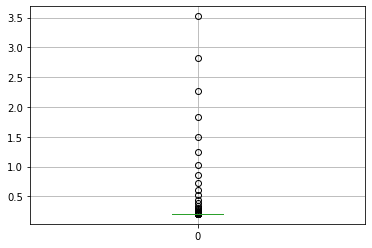

In [15]:
print(dtrain.describe())
dtrain.boxplot()
plt.show()

In [16]:
print("Best MAE on Validation Set =", max(history['val_mae']))

Best MAE on Validation Set = 0.4712308347225189


In [17]:
print("Best MSE on Validation Set =", max(history['val_mse']))

Best MSE on Validation Set = 0.3442881405353546


In [18]:
loss = model.evaluate(X_train, X_train, verbose=0)
print(loss)

[0.20661857724189758, 0.20635363459587097, 0.07110925763845444, 337.6478271484375, 0.015505998395383358, 0.8989148139953613]


In [19]:
for name, value in zip(model.metrics_names, loss):
    print(name, value)

loss 0.20661857724189758
mae 0.20635363459587097
mse 0.07110925763845444
mape 337.6478271484375
msle 0.015505998395383358
cosine_proximity 0.8989148139953613


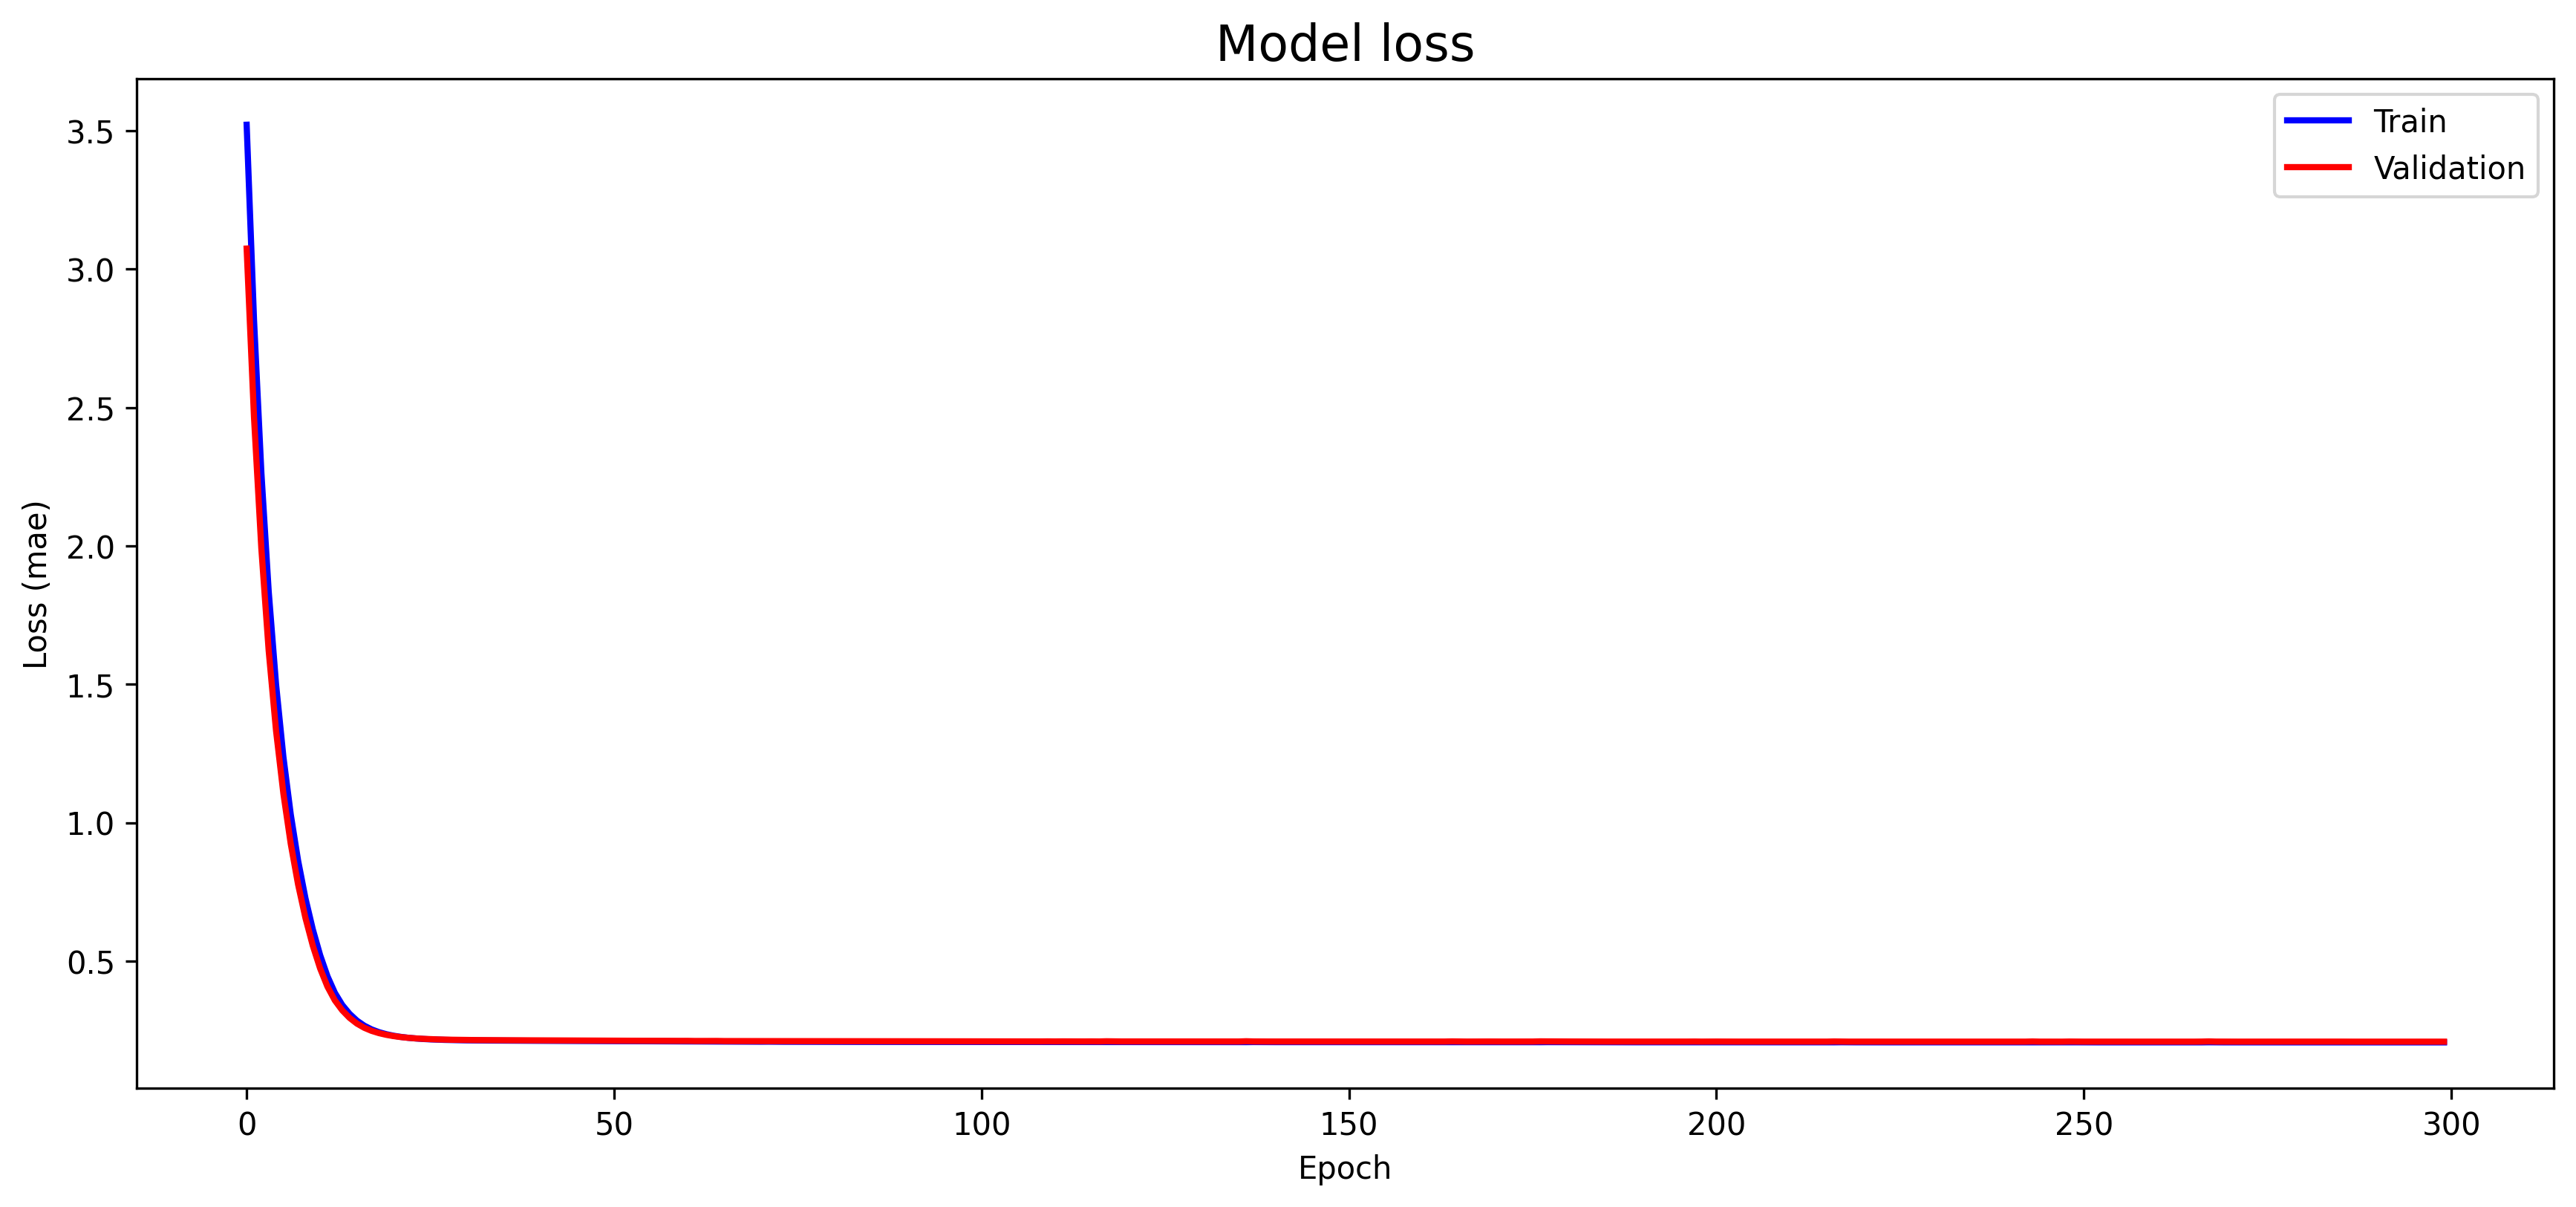

In [20]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()



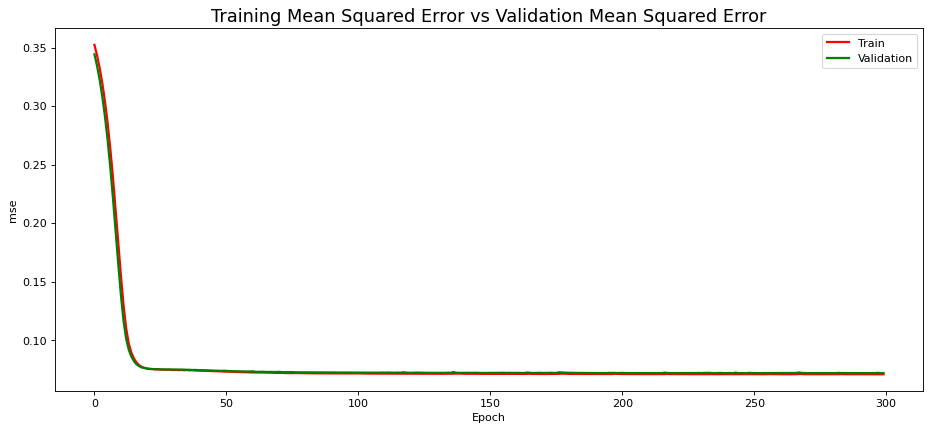

In [21]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['mse'], 'r', label='Train', linewidth=2)
ax.plot(history['val_mse'], 'g', label='Validation', linewidth=2)
ax.set_title('Training Mean Squared Error vs Validation Mean Squared Error', fontsize=16)
ax.set_ylabel('mse')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

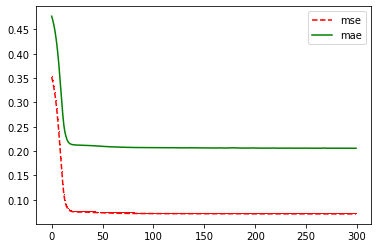

In [22]:
# plot metrics
plt.plot(history['mse'],'r--,', label='mse')
plt.plot(history['mae'],'g', label='mae')
plt.legend(loc='upper right')
plt.show()

## Distributon of Loss Function

/home/zan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

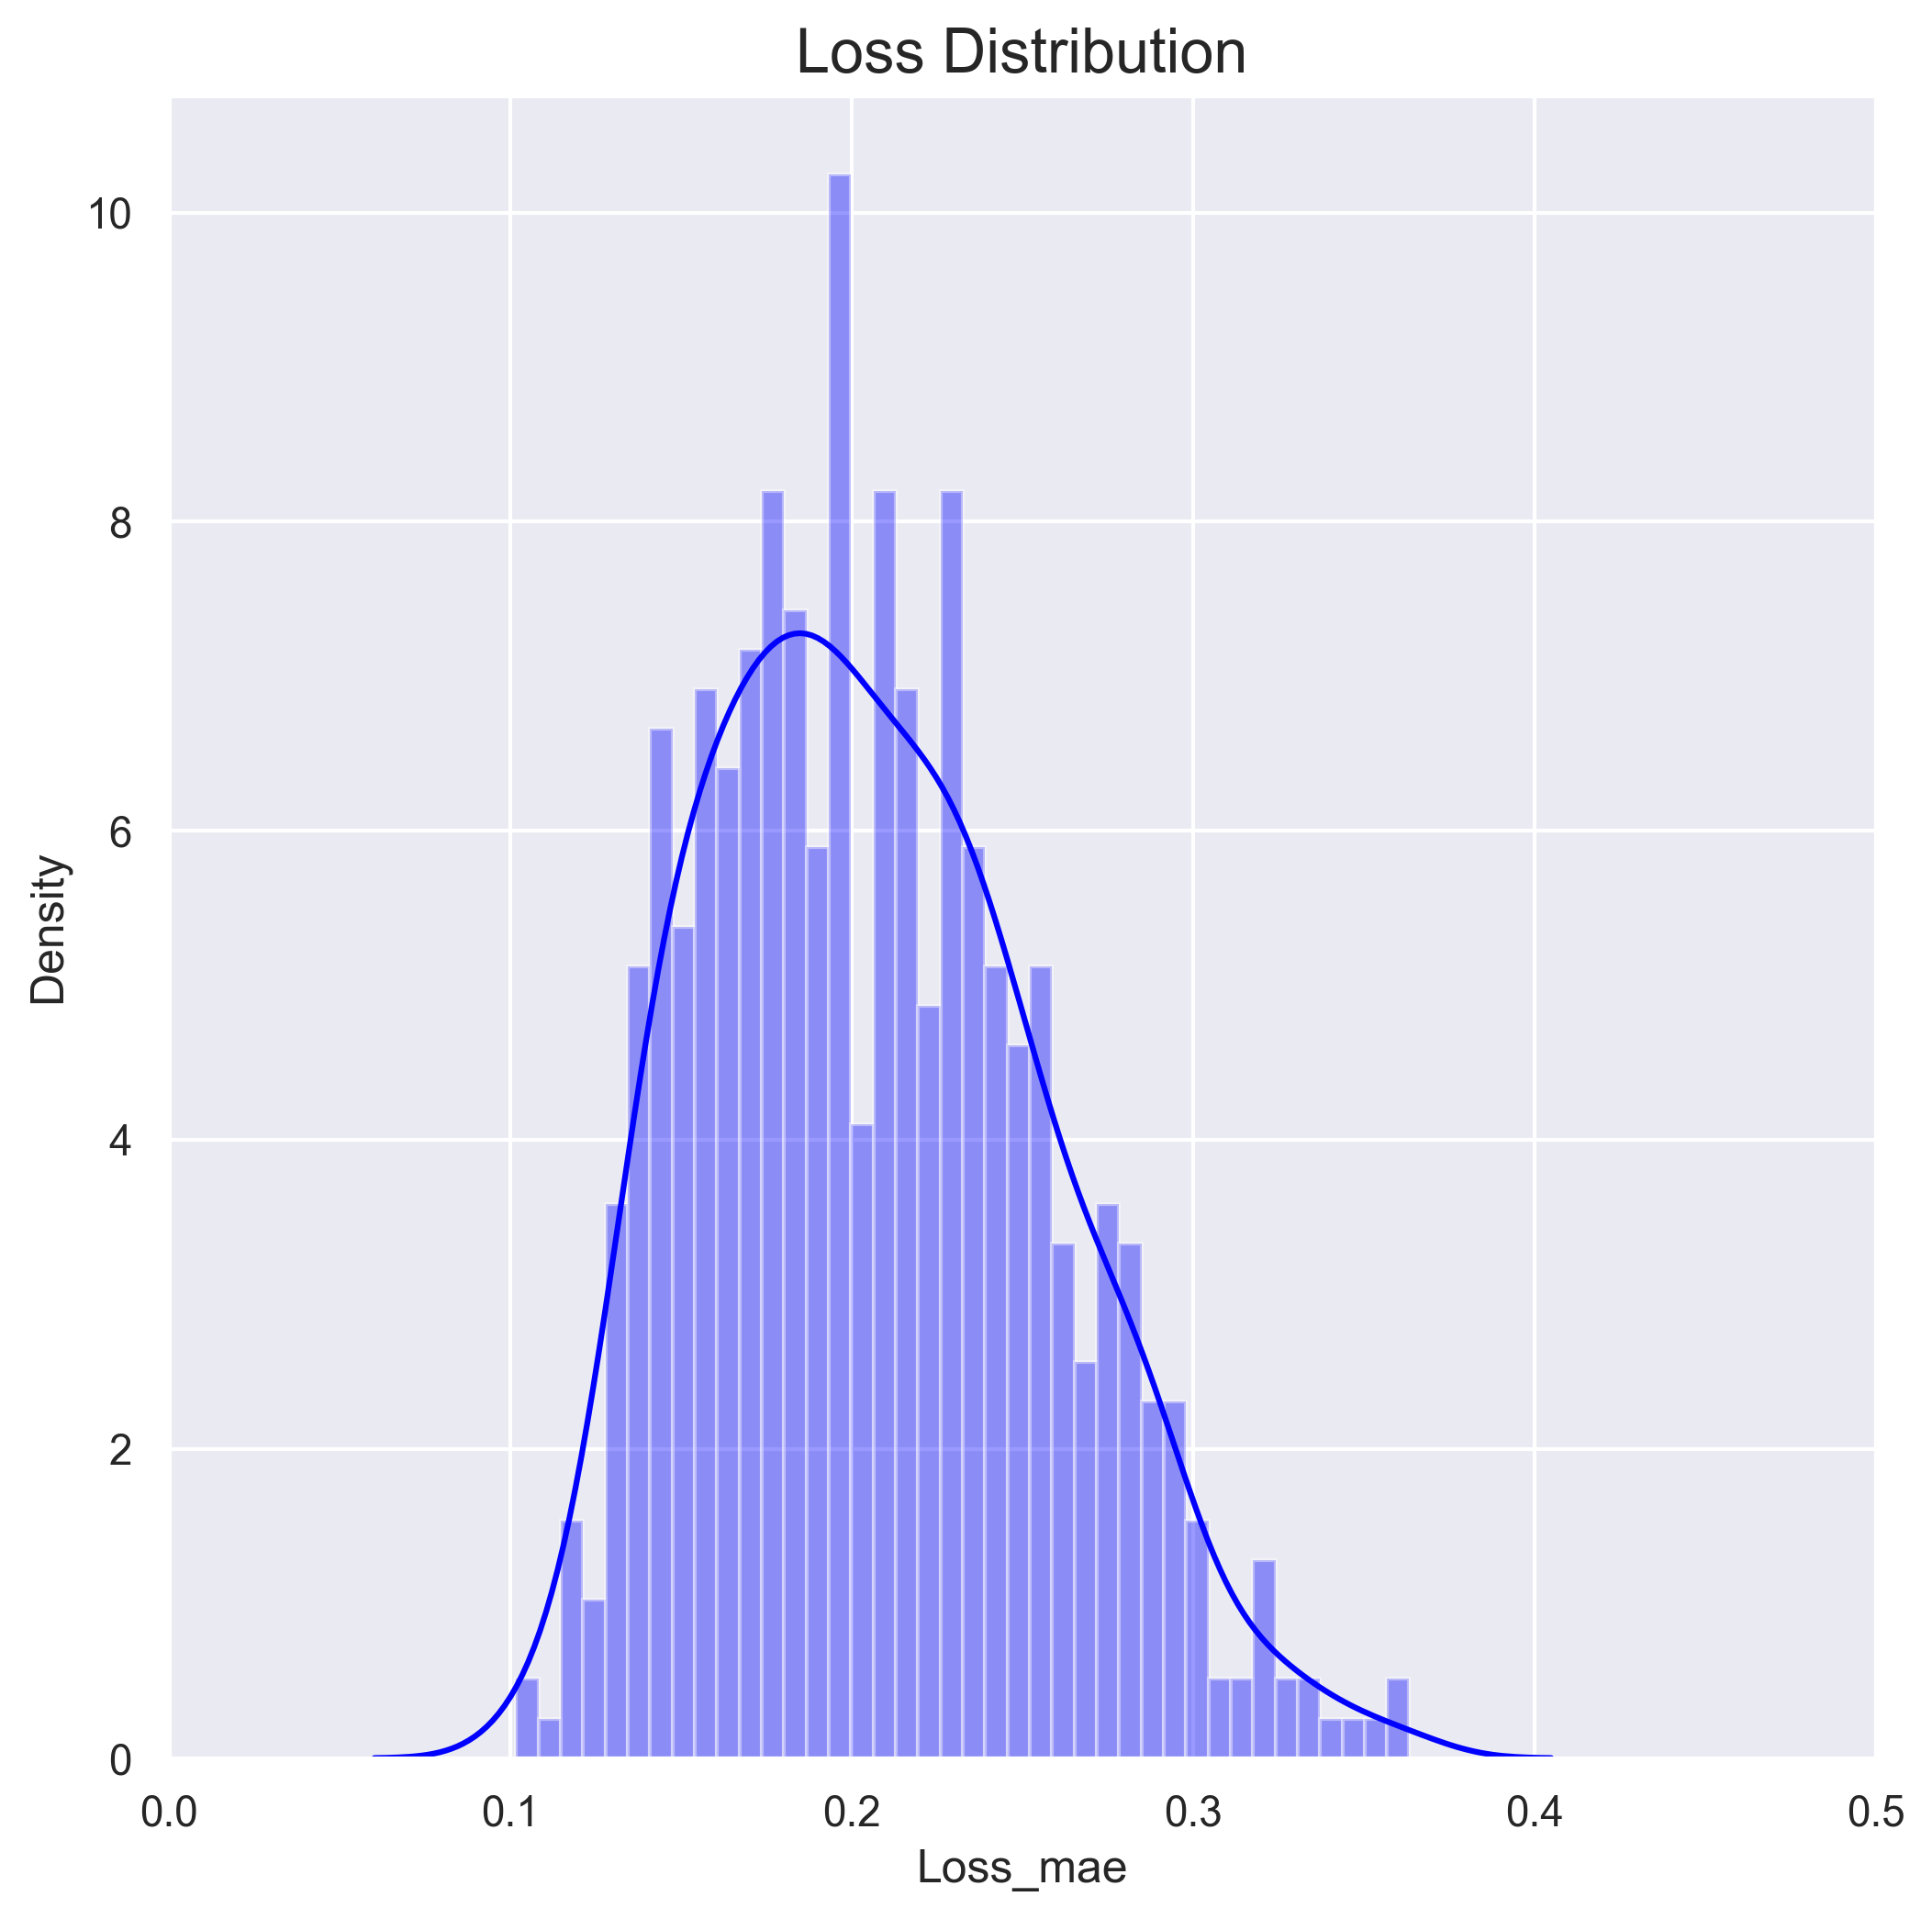

In [23]:
import seaborn as sns
sns.set(color_codes=True)

# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train_ext.columns)
X_pred.index = train_ext.index

scored_train = pd.DataFrame(index=train_ext.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored_train['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)

plt.figure(figsize=(8,8), dpi= 300)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored_train['Loss_mae'], color = 'blue', bins = 40, kde=True)
plt.xlim([0.00,0.5])


/home/zan/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


,Loss_mae,Threshold,Anomaly
0,0.659799,0.9,False
1,0.657382,0.9,False
2,0.658545,0.9,False
3,0.757936,0.9,False
4,0.815608,0.9,False


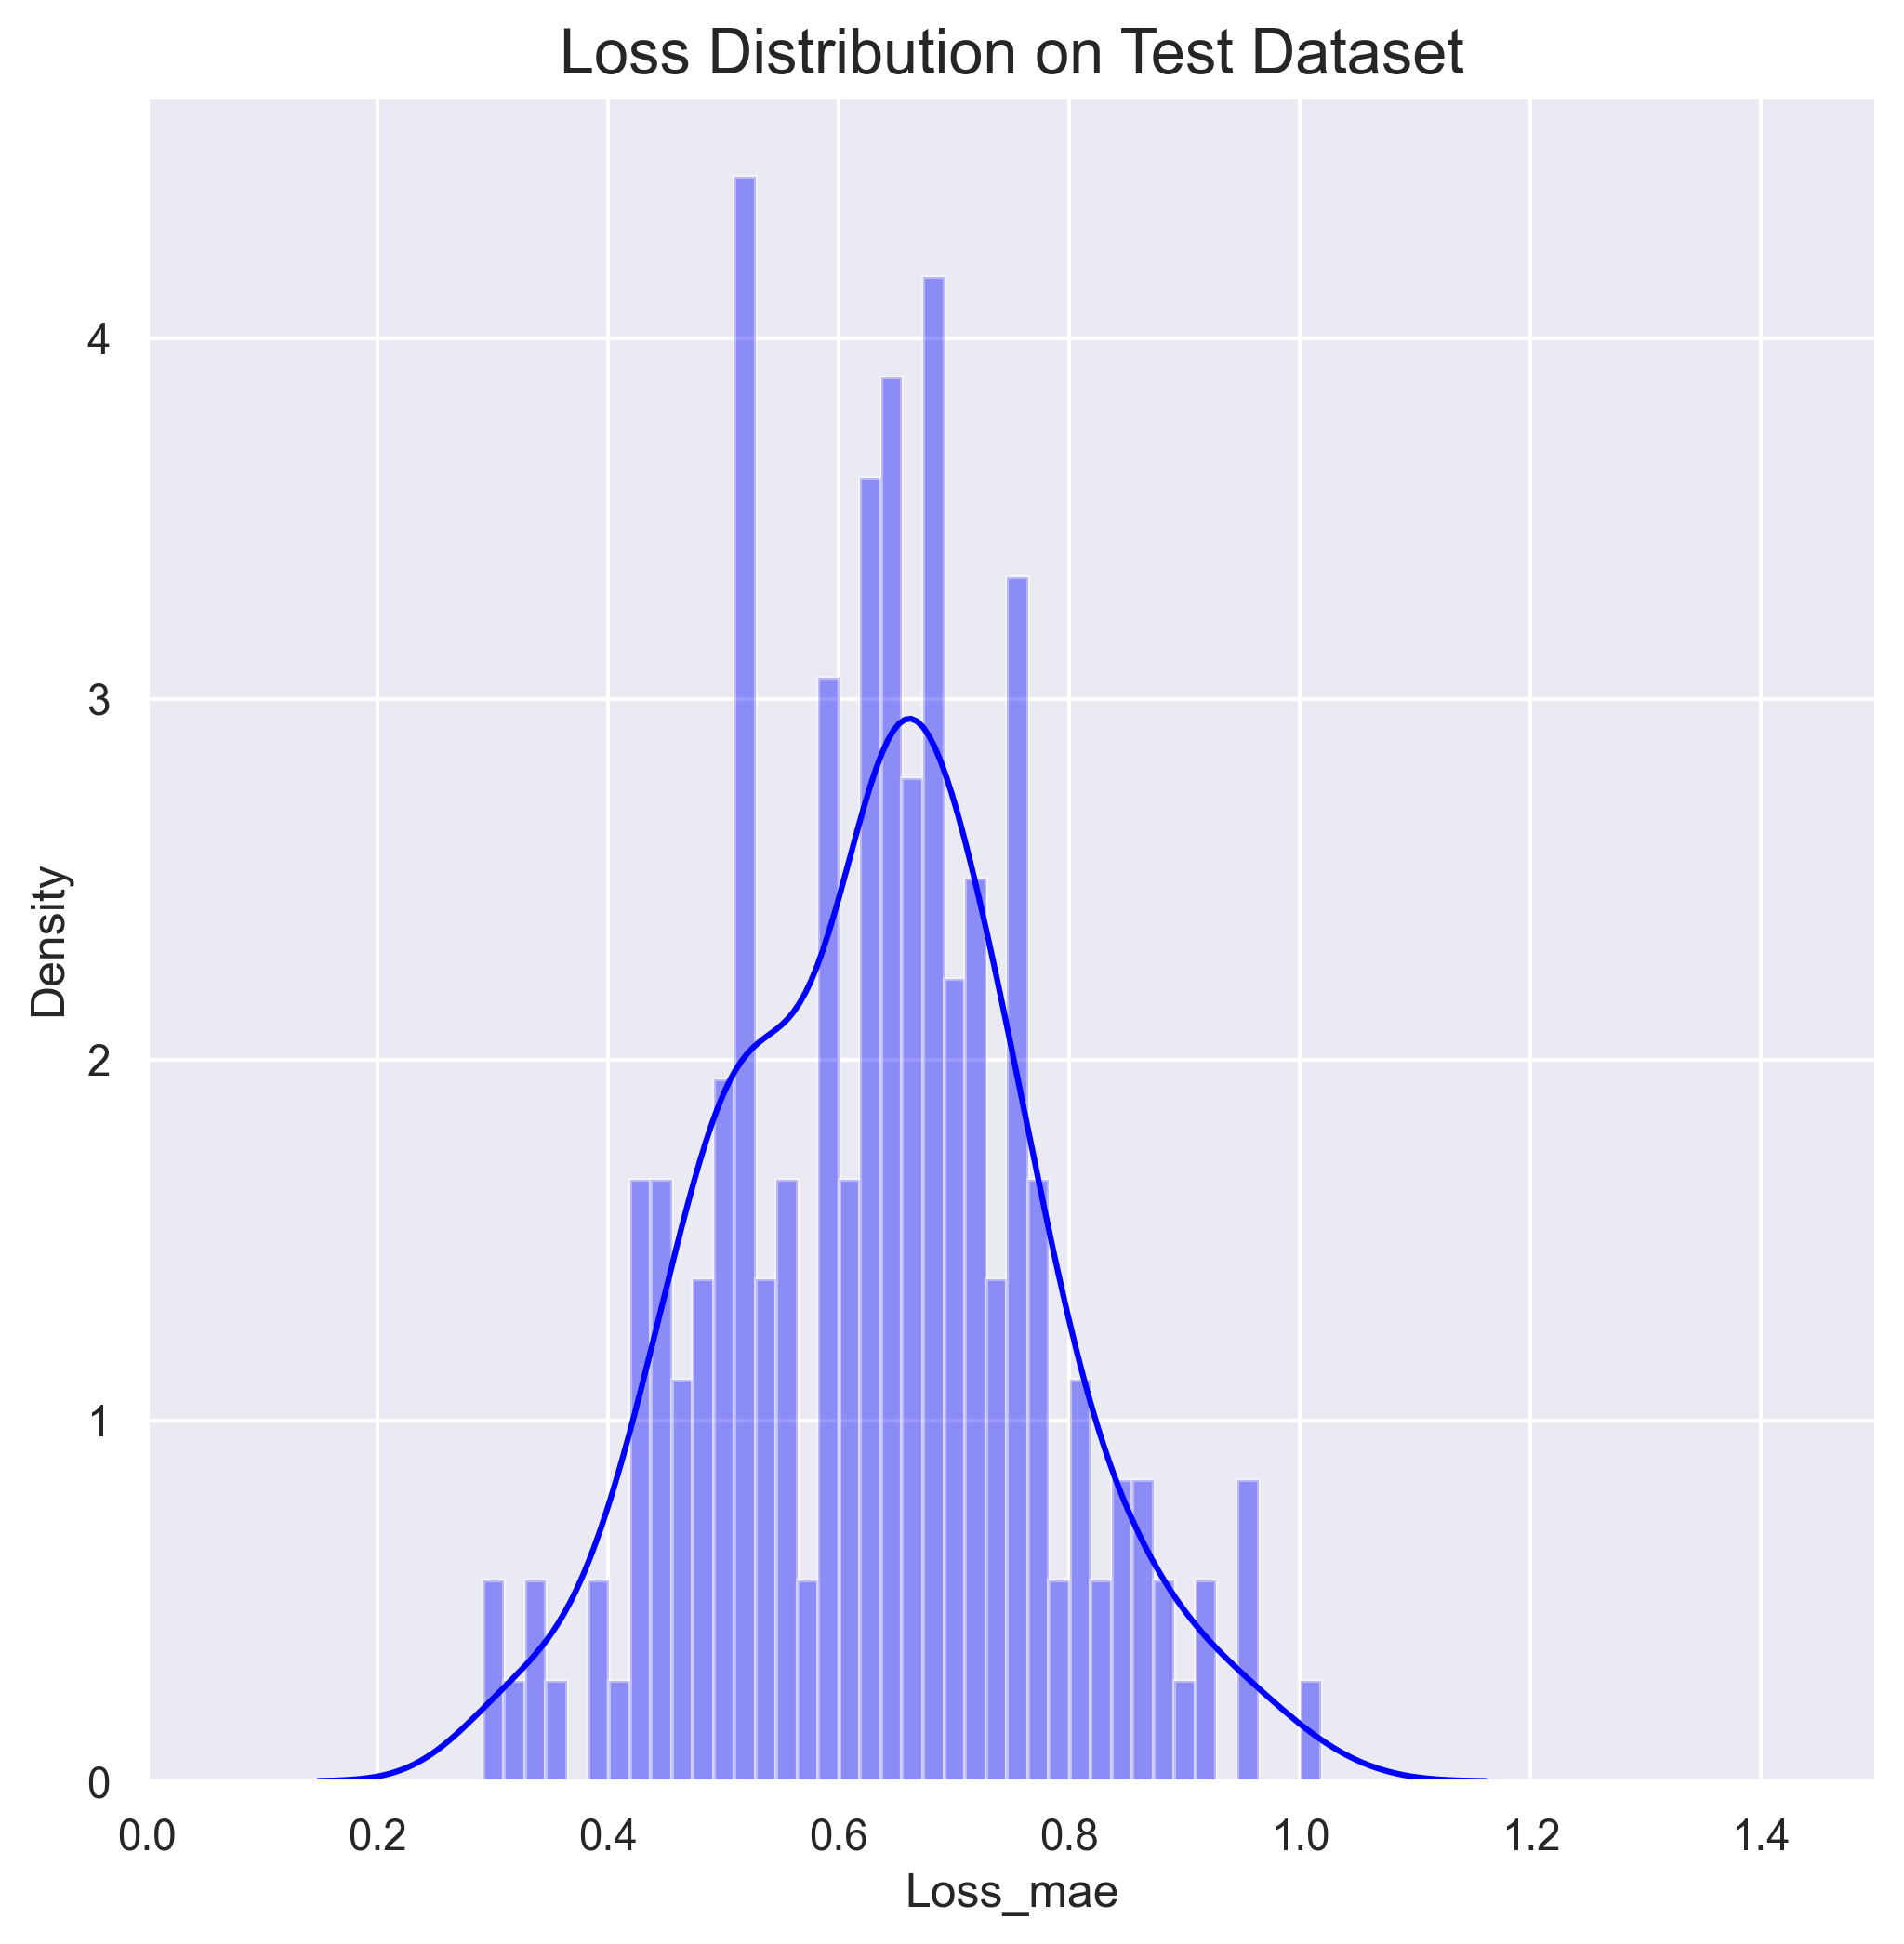

In [24]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test_ext.columns)
X_pred.index = test_ext.index


scored = pd.DataFrame(index=test_ext.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])

scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)

plt.figure(figsize=(8,8), dpi= 300)
plt.title('Loss Distribution on Test Dataset', fontsize=16)
sns.distplot(scored['Loss_mae'], color = 'blue', bins = 40, kde=True)
plt.xlim([0.00,1.5])
scored['Threshold'] = 0.9
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

In [25]:
scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Loss_mae   198 non-null    float32
 1   Threshold  198 non-null    float64
 2   Anomaly    198 non-null    bool   
dtypes: bool(1), float32(1), float64(1)
memory usage: 2.6 KB


In [26]:
data_filter = scored[scored['Anomaly'] == True]
data_filter.head(100)

,Loss_mae,Threshold,Anomaly
22,1.018334,0.9,True
53,0.959211,0.9,True
70,0.962875,0.9,True
73,0.952862,0.9,True
165,0.920261,0.9,True
179,0.924516,0.9,True


In [27]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train_ext.columns)
X_pred_train.index = train_ext.index

scored_train = pd.DataFrame(index=train_ext.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.9
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

<AxesSubplot:>

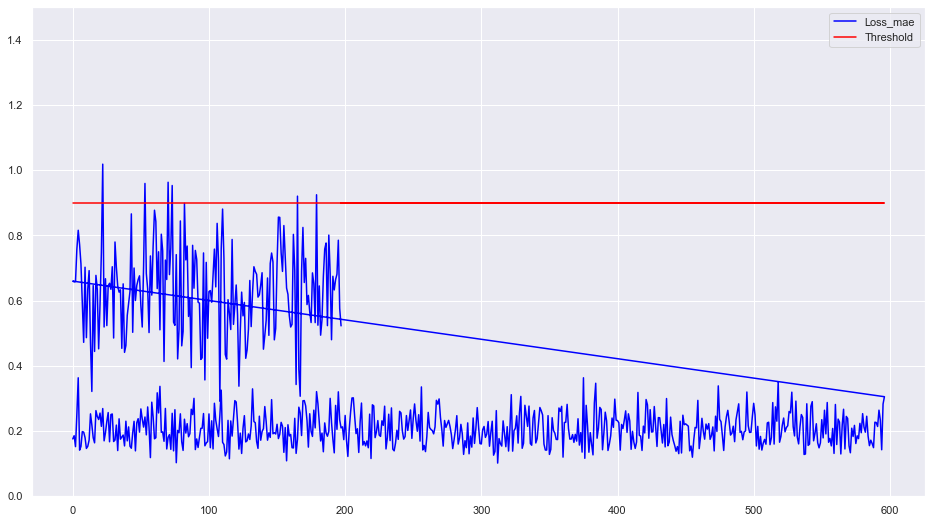

In [28]:
scored.plot(figsize=(16,9), ylim=[0,1.5], color=['blue','red'])

## Determinación de threshold con (max)

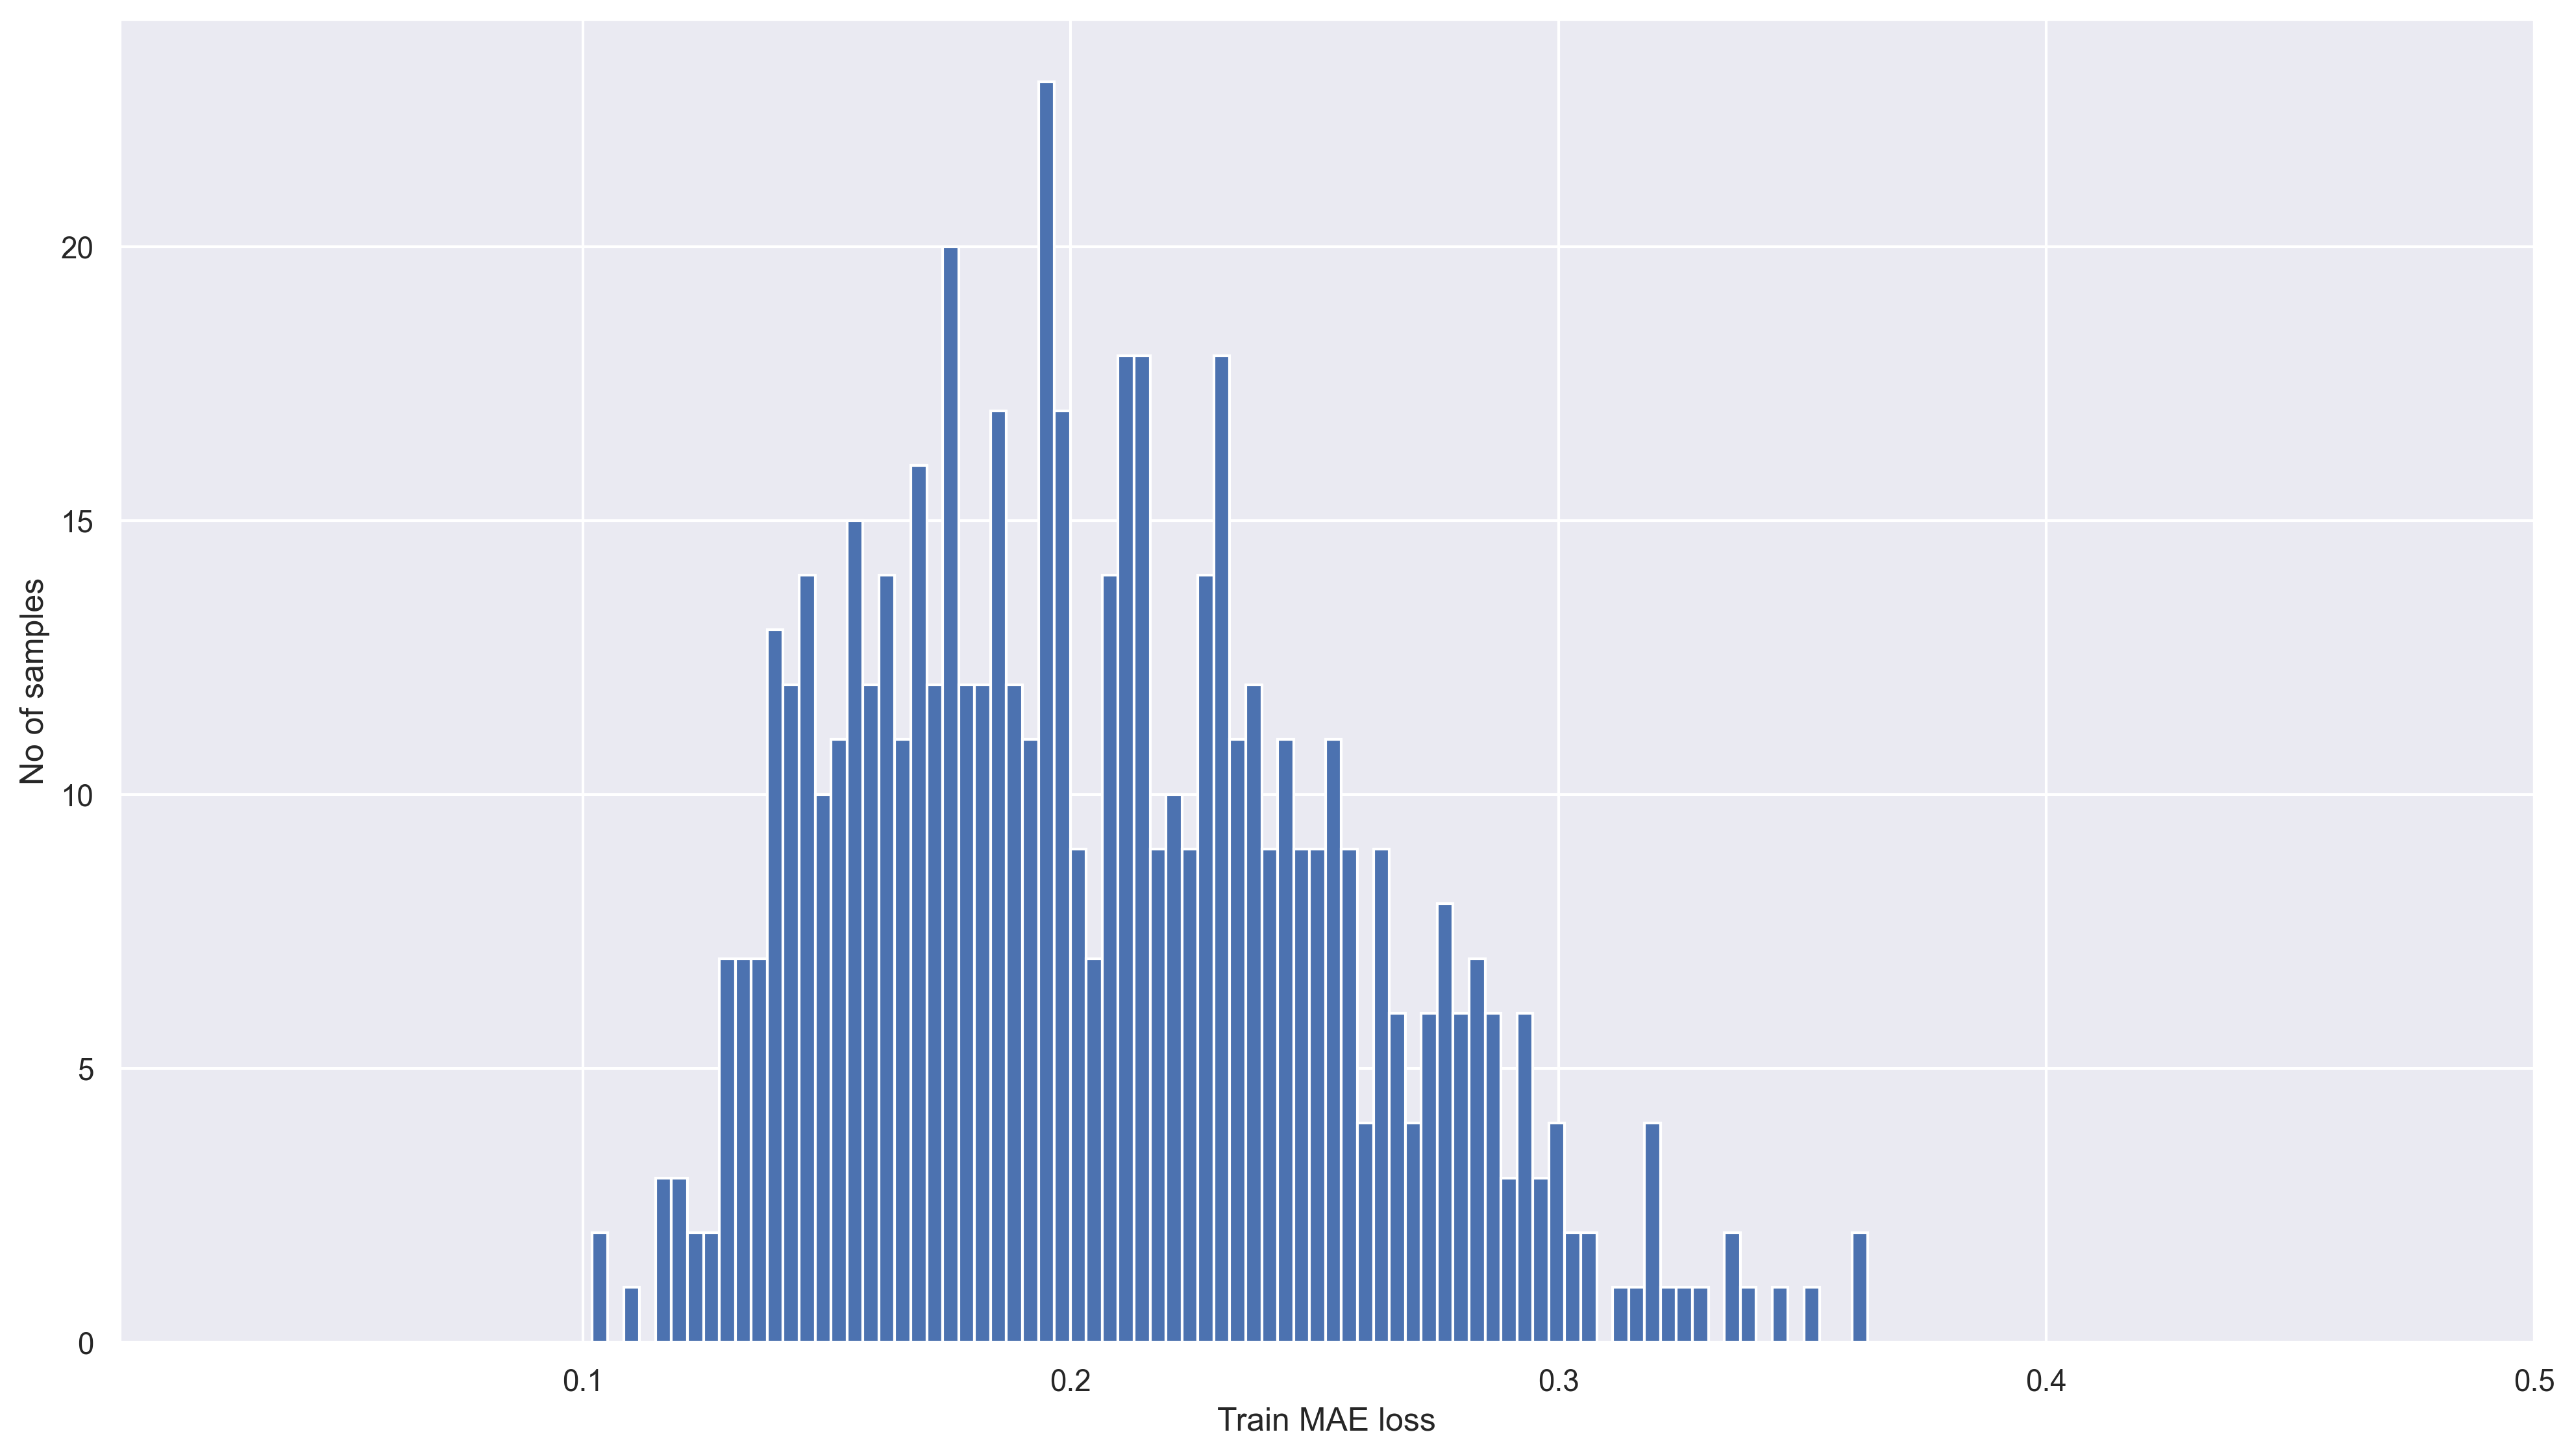

Reconstruction error threshold:  0.36340398


In [29]:
# Get train MAE loss.
x_train_pred = model.predict(X_train)
x_train_pred = x_train_pred.reshape(x_train_pred.shape[0], x_train_pred.shape[2])
x_train_pred = pd.DataFrame(x_train_pred, columns=train_ext.columns)
x_train_pred.index = train_ext.index

score = pd.DataFrame(index=train_ext.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
score['train_mae_loss'] = np.mean(np.abs(x_train_pred - Xtrain), axis=1)

plt.figure(figsize=(16,9), dpi= 300)
plt.hist(score['train_mae_loss'], bins= 80)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.xlim([0.005,0.5])
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(score['train_mae_loss'])
print("Reconstruction error threshold: ", threshold)


## Determinación de threshold con (mean + std)

In [30]:
reconstructions = model.predict(X_train)
train_loss = np.mean(np.abs(reconstructions - X_train), axis=1)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)


Threshold:  0.3752543


## Determinación de Clasificación. (dataset de train)

In [139]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, cohen_kappa_score, fbeta_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, log_loss
# calculate the loss on the train dataset
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train_ext.columns)
X_pred.index = train_ext.index


In [ ]:
error_df = pd.DataFrame(index=train_ext.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
error_df['Reconstruction_error'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
error_df['True_class'] = train_dec_a
error_df.head()

In [ ]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [ ]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=2, label='Precision-Recall curve')
plt.legend(loc='lower right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
threshold_fixed = 0.1
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "ANOMALY" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

## Confusion Matrix


In [ ]:
LABELS = ["Normal","ANOMALY"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Reconstruction error - Test set

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(error_df.Reconstruction_error[error_df.True_class==0], label='Normal', shade=True, clip=(0,10))
sns.kdeplot(error_df.Reconstruction_error[error_df.True_class==1], label='ANOMALY', shade=True, clip=(0,10))
plt.xlabel('Reconstruction error')
plt.title('Reconstruction error - Train set')


## Determinación de Clasificación. Test

In [31]:
# calculate the loss on the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, cohen_kappa_score, fbeta_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, log_loss
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test_ext.columns)
X_pred.index = test_ext.index


In [32]:
error_df = pd.DataFrame(index=test_ext.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
error_df['Reconstruction_error'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
error_df['True_class'] = test_dec_a
error_df.head()

## Otra variante
"""
mse = np.mean(np.power(Xtest - X_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()
"""

"\nmse = np.mean(np.power(Xtest - X_pred, 2), axis=1)\nerror_df = pd.DataFrame({'Reconstruction_error': mse,\n                        'True_class': test_y})\nerror_df.describe()\n"

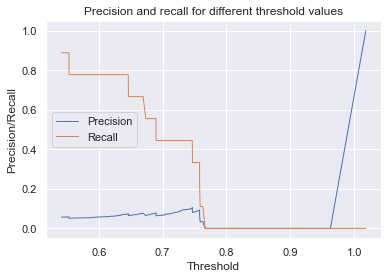

In [33]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=1)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=1)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()


In [34]:
print(threshold_rt)

[0.54139763 0.5515028  0.55319375 0.55340844 0.5547775  0.55530924
 0.56120104 0.56555563 0.57605785 0.58382845 0.5845882  0.58729035
 0.58770645 0.5877896  0.59169585 0.59214926 0.5944571  0.5949775
 0.5952591  0.6002854  0.60280454 0.60624754 0.6107587  0.61597365
 0.6168655  0.6174294  0.61924934 0.62451315 0.6259709  0.6260694
 0.62768215 0.6279302  0.630794   0.63268596 0.6330008  0.6340292
 0.63463753 0.6348171  0.63582754 0.6369711  0.63800335 0.6383946
 0.6420464  0.6440274  0.64502597 0.64544576 0.64614147 0.64645267
 0.64713806 0.6479109  0.65132964 0.6516872  0.65311295 0.6554899
 0.6573817  0.6585446  0.65979886 0.66173065 0.6642705  0.66454947
 0.66467434 0.6670572  0.66938937 0.6734825  0.67364657 0.67458016
 0.67600983 0.6773419  0.679735   0.6806249  0.68105024 0.68311113
 0.6831622  0.68499005 0.6854673  0.6895077  0.68964624 0.68967885
 0.69189537 0.693236   0.6999587  0.70236474 0.702474   0.70381796
 0.70384204 0.7060308  0.7126972  0.7137571  0.7139615  0.7171702
 

## ROC CURVE CHECK

Text(0.5, 0, 'False Positive Rate')

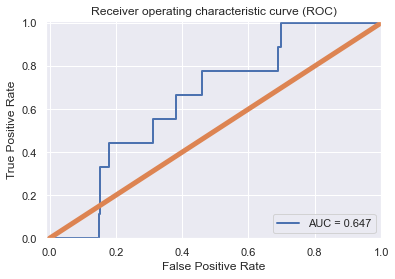

In [35]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=2, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


## RECALL VS PRECISION THRESHOLDING

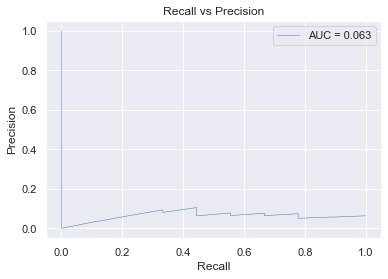

In [36]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
pr_auc = auc(recall_rt, precision_rt,)

plt.plot(recall_rt, precision_rt, linewidth=0.5, label='AUC = %0.3f'% pr_auc)
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


## Reconstruction Error vs Threshold Check

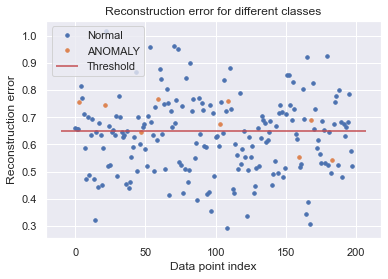

In [37]:
threshold_fixed = 0.65
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "ANOMALY" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()



## Confusion Matrix

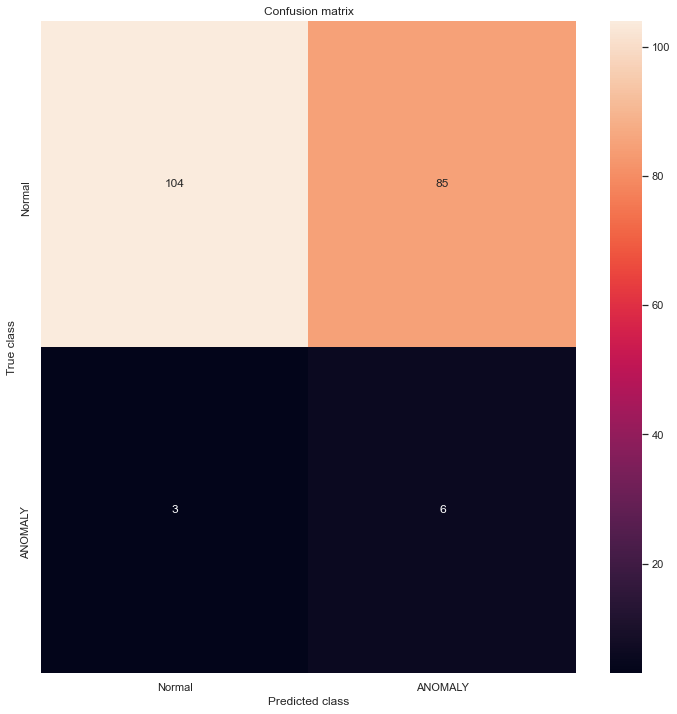

In [38]:
LABELS = ["Normal","ANOMALY"]

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()



## MODEL STATS

In [39]:
def print_stats(ytest, ypred):
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    ll = log_loss(ytest, ypred)
    print("Log Loss: {}".format(ll))
    print(' ')
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [40]:
print_stats(error_df.True_class, pred_y)

Accuracy: 0.55556, Cohen's Kappa Score: 0.04063
Log Loss: 15.350910548150035
 
Confusion Matrix:
[[104  85]
 [  3   6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.55      0.70       189
           1       0.07      0.67      0.12         9

    accuracy                           0.56       198
   macro avg       0.52      0.61      0.41       198
weighted avg       0.93      0.56      0.68       198



In [41]:
p = precision_score(error_df.True_class, pred_y,average='weighted')
r = recall_score(error_df.True_class, pred_y,average='weighted')
f = fbeta_score(error_df.True_class, pred_y, beta= 1,average='weighted')
print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))

Result: p=0.931, r=0.556, f=0.676


In [42]:
print("------------------------------------------------------------------------------")
for threshold_fixed in [0.4, 0.65, 0.7, 0.8]:
    pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
    conf_matrix = confusion_matrix(error_df.True_class, pred_y)
    #print(conf_matrix)
    p = precision_score(error_df.True_class, pred_y, average='weighted')
    r = recall_score(error_df.True_class, pred_y,average='weighted')
    f = fbeta_score(error_df.True_class, pred_y, beta= 1, average='weighted')
    print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))
    print('Threshold fixed=%.3f' % threshold_fixed)
    print_stats(error_df.True_class, pred_y)
    print("------------------------------------------------------------------------------")

------------------------------------------------------------------------------
Result: p=0.957, r=0.086, f=0.082
Threshold fixed=0.400
Accuracy: 0.08586, Cohen's Kappa Score: 0.00400
Log Loss: 31.574056841483323
 
Confusion Matrix:
[[  8 181]
 [  0   9]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08       189
           1       0.05      1.00      0.09         9

    accuracy                           0.09       198
   macro avg       0.52      0.52      0.09       198
weighted avg       0.96      0.09      0.08       198

------------------------------------------------------------------------------
Result: p=0.931, r=0.556, f=0.676
Threshold fixed=0.650
Accuracy: 0.55556, Cohen's Kappa Score: 0.04063
Log Loss: 15.350910548150035
 
Confusion Matrix:
[[104  85]
 [  3   6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.55      0.70       189
        